*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). January 2018.*

# [Tracking](https://github.com/ocelot-collab/ocelot/blob/dev/demos/ipython_tutorials/2_tracking.ipynb)

As an example, we will use lattice file (converted to Ocelot format) of the European XFEL Injector. 

##### This example will cover the following topics:
- calculation of the linear optics for the European XFEL Injector.
- Tracking of the particles in first and second order approximation without collective effects.

#### Coordinates
Coordinates in Ocelot are following:
$$ 
\left (x, \quad x' = \frac{p_x}{p_0} \right), \qquad \left (y, \quad y' = \frac{p_y}{p_0} \right), \qquad \left (\tau = c\Delta t, \quad p = \frac{\Delta E}{p_0 c} \right)
$$

### Definitions
- $\tau = c t - \frac{s}{\beta_0}$: Longitudinal coordinate of the particle.
- $s$: Independent variable representing the distance along the beam line (equivalent to the path length of the reference particle).
- $v_0$ and $p_0$: Velocity and momentum of the reference particle, respectively.
- $t$: Time at which a particle reaches position $s$ along the beam line.
- $\Delta E = E - E_0$, where $E = \gamma m_0 c^2$ is the total energy of the particle.

See more in [Ocelot Coordinate System](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/coordinate_system)

#### Requirements 
* injector_lattice.py - input file, the Injector lattice.
* beam_130MeV.ast    - input file, initial beam distribution in [ASTRA](http://www.desy.de/~mpyflo/) format.

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

# this python library provides generic shallow (copy) and 
# deep copy (deepcopy) operations 
from copy import deepcopy

import time

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import injector lattice
from injector_lattice import *

initializing ocelot...


If you want to see injector_lattice.py file you can run following command (lattice file is very large):
```
$ %load injector_lattice.py
```
The variable *cell* contains all the elements of the lattice in right order.

And again Ocelot will work with class [MagneticLattice](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice) instead of simple sequence of element. So we have to run following command. 


In [2]:
lat = MagneticLattice(cell, stop=None)

## 1. Design optics calculation for the EuXFEL Injector
For linear accelerators, the initial [Twiss](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss) parameters and initial beam energy must be defined to compute the optics.

To calculate Twiss paramters along the beamline [`twiss`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss) is used

<div class="alert alert-block alert-info">
<b>Note:</b> In the low-energy part of the accelerator, 
<a href="../../docu/physics-processes/sc.md">space charge</a> effects can significantly influence the beam dynamics. 
For simplicity, this tutorial does not consider any collective effects.
</div>
 

In [3]:
# initialization of Twiss object
tws0 = Twiss()
# defining initial twiss parameters
tws0.beta_x = 29.171
tws0.beta_y = 29.171
tws0.alpha_x = 10.955
tws0.alpha_y = 10.955
# defining initial electron energy in GeV
tws0.E = 0.005 

# calculate optical functions with initial twiss parameters
tws = twiss(lat, tws0, nPoints=None)

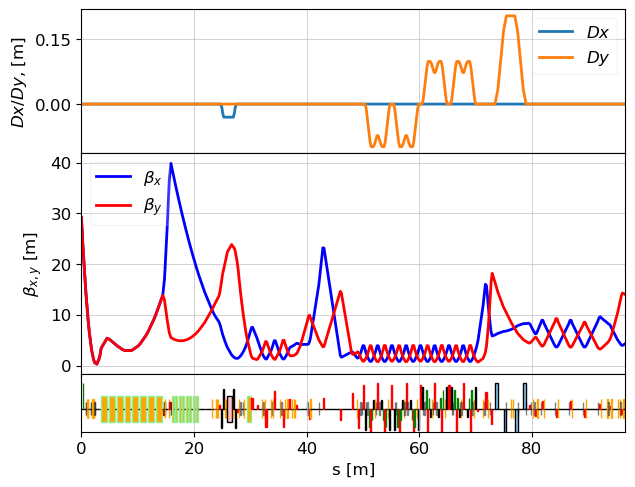

In [4]:
# ploting twiss paramentrs.
plot_opt_func(lat, tws, top_plot=["Dx", "Dy"], fig_name="i1", legend=False)
plt.show()


## 2. Tracking in First and Second Order Approximation (No Collective Effects)

In this section, we track a beam distribution generated by ASTRA, taken at the position 3.2 meters downstream from the gun cathode.
That is why, we need to start the Ocelot simulation from the same longitudinal position by setting the start argument of the [MagneticLattice](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice) object to the corresponding element in the beamline.


### Loading the Beam Distribution

To load a particle distribution, use the function `load_particle_array(FILENAME)`.  
- [ASTRA](http://www.desy.de/~mpyflo/)
- [CSRtrack](https://www.desy.de/xfel-beam/csrtrack/)
- Ocelot (`.npz`)

If you already used:
```python
from ocelot import *
```
you don’t need to import anything else. Otherwise, you can directly import the loader:
```python
from ocelot.cpbd.io import load_particle_array
```

This function returns a `ParticleArray` — Ocelot’s standard object for representing particle distributions.
More details can be found in the [ParticleArray documentation](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array).


In [5]:
#from ocelot.cpbd.io import load_particle_array

p_array_init = load_particle_array("sc_beam.npz")

### Defining the Lattice and Tracking Order

To configure the beamline and select the tracking method, use the [MagneticLattice](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice) class:
```python
MagneticLattice(sequence, start=None, stop=None, method={})
```

Arguments:
 - sequence: list of lattice elements
 - start: first element where tracking should begin
 - stop: last element (optional)
 - method: dictionary to assign transfer maps globally or per element

Example:
 `method = {"global": SecondTM}`

Predefined transfer maps include:
 - TransferMap: first-order matrix
 - SecondTM: second-order matrix
 - KickTM: single-kick tracking
 - RungeKuttaTM: numerical integration using element.mag_field

More details are available in the [MagneticLattice](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice). 


In [6]:
# initialization of tracking method
method = {"global": SecondTM}

# for first order tracking uncomment next line
# method = {"global": TransferMap}

# we start simulation from the first quadrupole (QI.46.I1) after RF section.
# you can change stop element (and the start element, as well) 
# START_73_I1 - marker before Dog leg
# START_96_I1 - marker before Bunch Compresion
lat_t = MagneticLattice(cell, start=start_sim, stop=None, method=method)

## Tracking

To perform tracking, you need to define the following objects:

### [`Navigator`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/navigator)

The [`Navigator`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/navigator) controls how the beam distribution ([`ParticleArray`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array)) is propagated through the lattice.  
It defines the tracking step size (`unit_step`) and where physical processes (e.g. space charge, CSR) are applied.

To add collective effects, use the method:
```python
navi.add_physics_proc(physics_proc, elem1, elem2)
```
 - `physics_proc`: the physics process (e.g. SpaceCharge, CSR, Wake)
 - `elem1`, `elem2`: the range of elements where the process will be applied

Navigator attributes:
 - unit_step = 1 (default): step size [m] for applying physics processes

<div class="alert alert-block alert-warning">
<b>Warning:</b> The <code>unit_step</code> is ignored if no physics processes are added 
(excluding kick-like ones such as <code>BeamTransform</code>). In this case, tracking is done element-by-element.
</div>

### [`track()`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/tracking) function
The [`track()`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/tracking) function propagates a ParticleArray through a MagneticLattice.
It also calculates beam Twiss parameters at each step (optional).

```python
tws_list, p_array_out = track(lattice, p_array, navi)
```
Main arguments:
 - lattice: [MagneticLattice](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice) object
 - p_array: input [`ParticleArray`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array)
 - navi: [`Navigator`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/navigator) instance

Returns:
 - tws_list: list of [Twiss](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss) objects (empty if calc_tws=False)
 - p_array_out: final [`ParticleArray`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array) after tracking


In [7]:
navi = Navigator(lat_t)
p_array = deepcopy(p_array_init)
start = time.time()
tws_track, p_array = track(lat_t, p_array, navi)
print("\n time exec:", time.time() - start, "sec")

z = 93.40410100084 / 93.40410100084006. Applied: d:  
 time exec: 13.018640041351318 sec


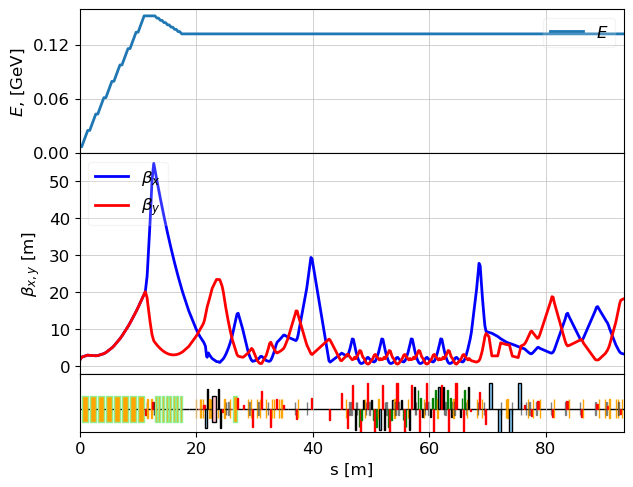

In [8]:
# you can change top_plot argument, for example top_plot=["alpha_x", "alpha_y"]
plot_opt_func(lat_t, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()

#### Tracking with Beam Matching

To match the beam to the design optics, you can apply an artificial transformation using [`BeamTransform`](https://www.ocelot-collab.com/docs/docu/physics-processes/beamtransform) physics process:

The [`BeamTransform`](https://www.ocelot-collab.com/docs/docu/physics-processes/beamtransform) process transform the particle distribution to match the specified Twiss parameters.


z = 93.40410100084 / 93.40410100084006. Applied: d:  mTransform
 time exec: 12.16694188117981 sec


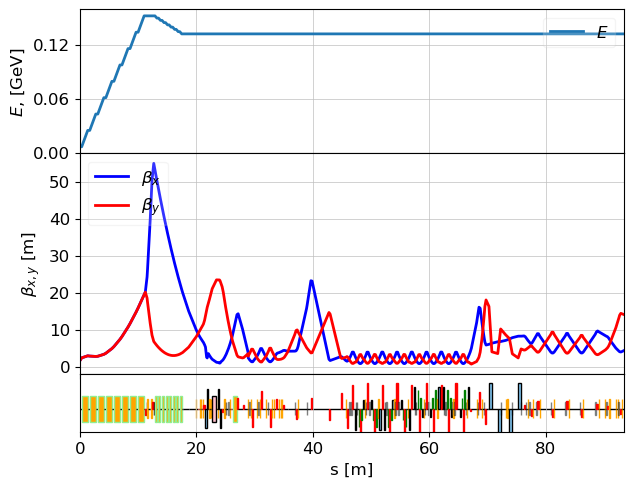

In [9]:
tw = Twiss()
tw.beta_x = 2.36088
tw.beta_y = 2.824
tw.alpha_x = 1.2206
tw.alpha_y = -1.35329

bt = BeamTransform(tws=tw)

navi = Navigator(lat_t)

navi.unit_step = 1 # ignored in that case, tracking will performs element by element. 
                   # - there is no PhysicsProc along the lattice, 
                   # BeamTransform is aplied only once

navi.add_physics_proc(bt, OTRC_55_I1, OTRC_55_I1)
p_array = deepcopy(p_array_init)
start = time.time()
tws_track, p_array = track(lat_t, p_array, navi)
print("\n time exec:", time.time() - start, "sec")
plot_opt_func(lat_t, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()

## New in version 25.06

In the **dispersion section**, the **transverse beam sizes** (in the plane of dispersion) may be **calculated incorrectly** by default.  
To correct this, set the argument `twiss_disp_correction=True` when calling the [`track`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/tracking) function:

```python
tws_track, p_array = track(lat_t, p_array, navi, twiss_disp_correction=True)
```
see more in Documentation about [`track`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/tracking).

z = 93.40410100084 / 93.40410100084006. Applied: d:  mTransform
 time exec: 12.553806781768799 sec


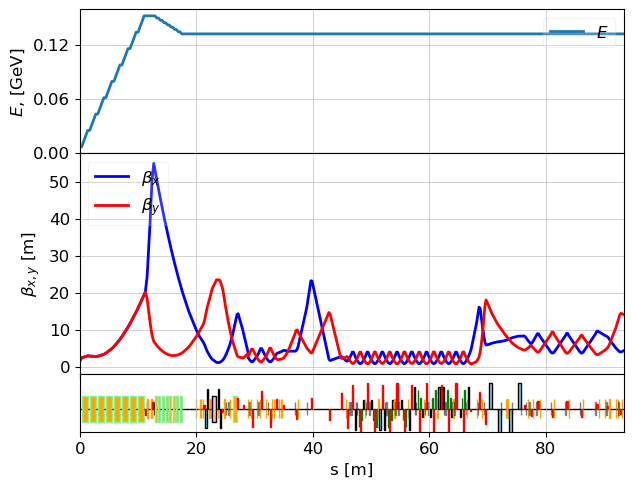

In [14]:
tw = Twiss()
tw.beta_x = 2.36088
tw.beta_y = 2.824
tw.alpha_x = 1.2206
tw.alpha_y = -1.35329

bt = BeamTransform(tws=tw)

navi = Navigator(lat_t)

navi.unit_step = 1 # ignored in that case, tracking will performs element by element. 
                   # - there is no PhysicsProc along the lattice, 
                   # BeamTransform is aplied only once

navi.add_physics_proc(bt, OTRC_55_I1, OTRC_55_I1)
p_array = deepcopy(p_array_init)
start = time.time()
tws_track, p_array = track(lat_t, p_array, navi, twiss_disp_correction=True)
print("\n time exec:", time.time() - start, "sec")
plot_opt_func(lat_t, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()


<div class="alert alert-block alert-info">
<b>Note:</b> The <a href="https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/tracking"><code>track()</code></a> function returns a list of 
<a href="https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss"><code>Twiss</code></a> objects (<code>tws_track</code>) and the final 
<a href="https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array"><code>ParticleArray</code></a> (<code>p_array</code>).<br>
The <code>Twiss</code> objects contain key beam properties such as size, position, emittance, and second moments at each step along the lattice.
</div>

You can extract common beam parameters like this:

- Beam trajectory (center of mass):
```python
x = [tw.x for tw in tws_track]
```
Or beam size::
```python
sigma_x = np.sqrt([tw.xx for tw in tws_track])
```
of bunch length:
```python
sigma_tau = np.sqrt([tw.tautau for tw in tws_track])
```

More about beam parameter calculations can be found in the [`get_envelope()`](https://www.ocelot-collab.com/docs/docu/functions/get_envelope) function.

### Example 


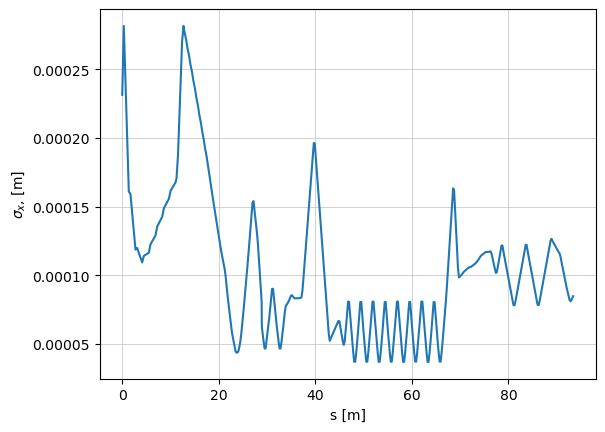

In [10]:
sigma_x = np.sqrt([tw.xx for tw in tws_track])
s = [tw.s for tw in tws_track]

plt.plot(s, sigma_x)
plt.xlabel("s [m]")
plt.ylabel(r"$\sigma_x$, [m]")
plt.show()


#### Beam distribution

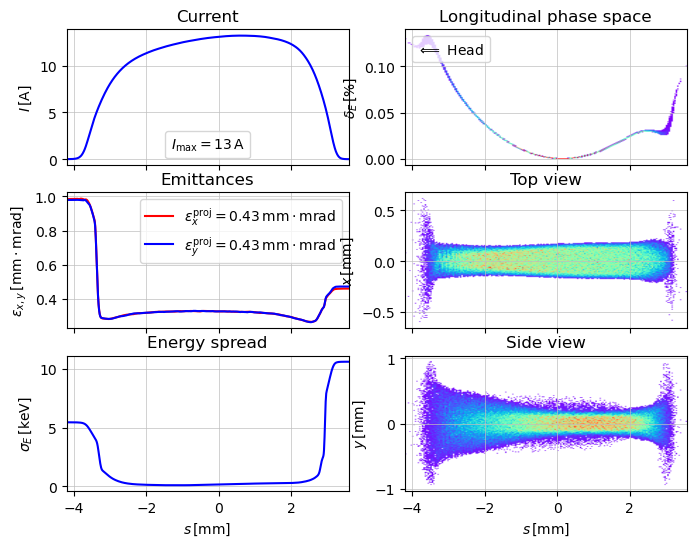

In [11]:
# the beam head is on left side 
show_e_beam(p_array, figsize=(8,6))

### Explicit usage of matplotlib functions
#### Current profile

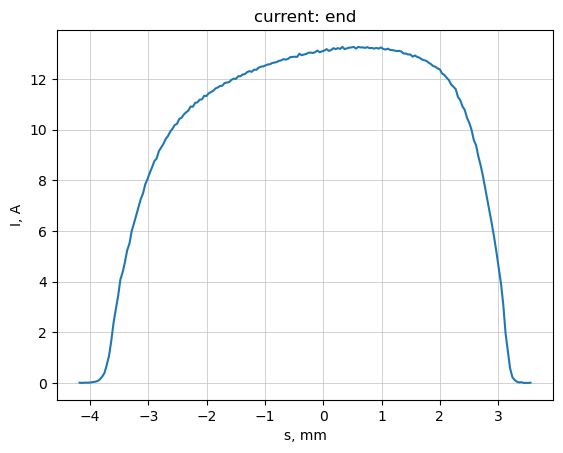

In [12]:
bins_start, hist_start = get_current(p_array, num_bins=200)

plt.figure(4)
plt.title("current: end")
plt.plot(bins_start*1000, hist_start)
plt.xlabel("s, mm")
plt.ylabel("I, A")
plt.grid(True)
plt.show()

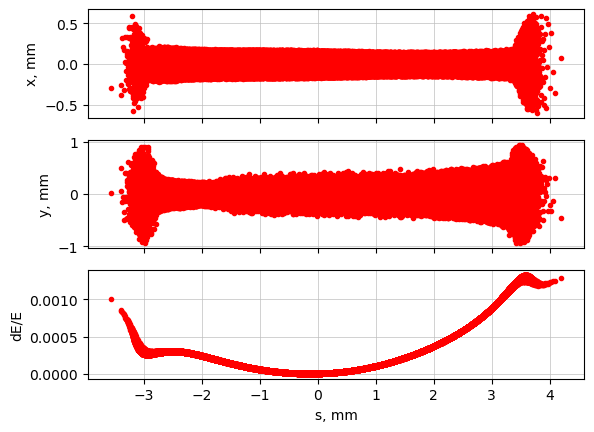

In [13]:
tau = np.array([p.tau for p in p_array])
dp = np.array([p.p for p in p_array])
x = np.array([p.x for p in p_array])
y = np.array([p.y for p in p_array])

ax1 = plt.subplot(311)
# inverse head and teil. The beam head is right side
ax1.plot(-tau*1000, x*1000, 'r.')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel("x, mm")
plt.grid(True)

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(-tau*1000, y*1000, 'r.')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel("y, mm")
plt.grid(True)

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(-tau*1000, dp, 'r.')
plt.ylabel("dE/E")
plt.xlabel("s, mm")
plt.grid(True)
plt.show()